In [101]:
# Set up libraries
import numpy as np
import pdb as pdb
import matplotlib.pyplot as plt
import time
import laspy
from mpl_toolkits.mplot3d import axes3d

In [102]:
# Set up color tables
x = np.linspace(0.0, 1.0, 256)
rainbow_rgb = plt.get_cmap("rainbow")(x)[np.newaxis, :, :3]

In [103]:
# Define up constants
air_index_of_refraction = 1.0003
c = 2.99792458e8   
number_of_waveform_files = 5000

In [104]:
# Open AOP Pulsewaves file and corresponding lidar point cloud
# Switch between windows and mac
# aop_data_dir = 'C:\\Users\\felixyu\\Documents\\GitHub\\Neon-Pls-Wvs-Analysis\\data\\'
aop_data_dir = '/Users/felixyu/Documents/Remote-Sensing/Neon-Pls-Wvs-Las/data/'
waveform_file = aop_data_dir + 'lidar.pls'

point_cloud_file_las = '/Users/felixyu/Documents/Remote-Sensing/Neon-Pls-Wvs-Las/data/NEON_D01_HARV_DP1_L006-1_2017081715_unclassified_point_cloud.las'
point_cloud_file_laz = '/Users/felixyu/Documents/Remote-Sensing/Neon-Pls-Wvs-Las/data/NEON_D01_HARV_DP1_L006-1_2017081715_unclassified_point_cloud.laz'

In [105]:
# Define a function to detect peaks in the waveform
def waveform_peak_detection(waveform,waveform_intensity_threshold):
    # Define x grid
    x_grid = np.arange(0.0,len(waveform),1.0)

    # Calculate 1st and 2nd derivatives
    deriv_1st = np.gradient(waveform,axis=0,edge_order=1)
    deriv_2nd = np.gradient(deriv_1st,axis=0,edge_order=1)

    #Find locations where 1st derivative crosses 0: (deriv_1st[i] * deriv_1st[i-1] = negative value)
    mult_shift_deriv_1st = deriv_1st * np.roll(deriv_1st,1)
    zero_slope_aoi = np.argwhere(mult_shift_deriv_1st <= 0.0)
    zero_slope_aoi = zero_slope_aoi[:,0]
    zero_slope_count = len(zero_slope_aoi)
    if zero_slope_count > 0:
        zero_slope_aoi = np.reshape(zero_slope_aoi,len(zero_slope_aoi))

    if zero_slope_count == 0:
        return_location_count = 0
        return_peak_location_list = -9999
        return_location_list_x = -9999
        return_intensity_list = -9999    
    else:
        if zero_slope_count == 1:    
            if zero_slope_aoi == 0:
                return_location_count = 0
                return_peak_location_list = -9999
                return_location_list_x = -9999
                return_intensity_list = -9999
            else:
                if deriv_2nd[zero_slope_aoi] < 0.0:
                    return_location_count = 1
                    return_peak_location_list = zero_slope_aoi
                    return_location_list_x = x_grid[zero_slope_aoi]
                    return_intensity_list = waveform[zero_slope_aoi]               
                else:
                    return_location_count = 0
                    return_peak_location_list = -9999
                    return_location_list_x = -9999
                    return_intensity_list = -9999    
        else:
                #Remove bin 0 if included in list
            if zero_slope_aoi[0] == 0:
                zero_slope_aoi = zero_slope_aoi[1:zero_slope_count]
                zero_slope_count = zero_slope_count - 1        
                #Remove sequential bins if included in list and keep first                
            zero_slope_aoi_diff = zero_slope_aoi - np.roll(zero_slope_aoi,1)
            good_zero_slope_aoi = np.argwhere(zero_slope_aoi_diff != 1)
            good_zero_slope_aoi = np.reshape(good_zero_slope_aoi,len(good_zero_slope_aoi))
            zero_slope_aoi = zero_slope_aoi[good_zero_slope_aoi]
            zero_slope_count = len(good_zero_slope_aoi)
            zero_slope_aoi_diff = 0
            good_zero_slope_aoi = 0       
                #Return peaks will have a negative 2nd derivative
            peak_locations_aoi = np.argwhere(deriv_2nd[zero_slope_aoi] < 0.0)
            return_location_count = len(peak_locations_aoi)
            if return_location_count > 0:
                peak_locations_aoi = peak_locations_aoi[:,0]
                peak_locations_aoi = np.reshape(peak_locations_aoi,len(peak_locations_aoi))
                return_peak_location_list = zero_slope_aoi[peak_locations_aoi]
                return_location_list_x = x_grid[zero_slope_aoi[peak_locations_aoi]]
                return_intensity_list = waveform[return_peak_location_list]
            else:
                return_peak_location_list = -9999
                return_location_list_x = -9999
                return_intensity_list = -9999
            peak_locations_aoi = 0

    if return_location_count > 0:
        return_peak_location_list = np.reshape(return_peak_location_list,return_location_count)
        return_location_list_x = np.reshape(return_location_list_x,return_location_count)
        return_intensity_list = np.reshape(return_intensity_list,return_location_count)
                     
        #Remove peaks with peak location at first 2 bins
    if return_location_count > 0:
        good_return_aoi = np.argwhere(return_peak_location_list > 1)
        good_return_count = len(good_return_aoi)
        if good_return_count > 0:
            good_return_aoi = np.reshape(good_return_aoi,good_return_count)
            return_location_count = good_return_count
            return_peak_location_list = return_peak_location_list[good_return_aoi]
            return_location_list_x = return_location_list_x[good_return_aoi]
            return_intensity_list = return_intensity_list[good_return_aoi]
        else:
            return_location_count = 0
            return_peak_location_list = -9999
            return_location_list_x = -9999
            return_intensity_list = -9999        
        good_return_aoi = 0                    

        #Check intensity values for valid peaks
    if return_location_count > 0:
        good_return_aoi = np.argwhere(return_intensity_list >= waveform_intensity_threshold)
        good_return_count = len(good_return_aoi)
        if good_return_count > 0:
            good_return_aoi = np.reshape(good_return_aoi,good_return_count)
            return_location_count = good_return_count
            return_peak_location_list = return_peak_location_list[good_return_aoi]
            return_location_list_x = return_location_list_x[good_return_aoi]
            return_intensity_list = return_intensity_list[good_return_aoi]
        else:
            return_location_count = 0
            return_peak_location_list = -9999
            return_location_list_x = -9999
            return_intensity_list = -9999        
        good_return_aoi = 0    
    
    x_grid = 0
    deriv_1st = 0
    deriv_2nd = 0
    mult_shift_deriv_1st = 0
    zero_slope_aoi = 0
    waveform = 0
    return return_location_count, return_peak_location_list, return_location_list_x, return_intensity_list

In [106]:
# Define a function to read a PulseWaves pls file
def read_NEONAOP_pulsewaves_pulse_information(pls_file):
    readbin_pls_file = open(pls_file,"rb")
    readbin_pls_file.seek(0,0)
    # Read PulseWaves Header
    file_signature = np.fromfile(readbin_pls_file,np.int8,16)
    global_parameters = np.fromfile(readbin_pls_file,np.uint32,1)
    file_source_id = np.fromfile(readbin_pls_file,np.uint32,1)
    project_id_guid_data1 = np.fromfile(readbin_pls_file,np.uint32,1)
    project_id_guid_data2 = np.fromfile(readbin_pls_file,np.uint16,1)
    project_id_guid_data3 = np.fromfile(readbin_pls_file,np.uint16,1)
    project_id_guid_data4 = np.fromfile(readbin_pls_file,np.uint8,8)
    system_identifier = np.fromfile(readbin_pls_file,np.int8,64)    
    generating_software = np.fromfile(readbin_pls_file,np.int8,64)
    file_creation_day_of_year = np.fromfile(readbin_pls_file,np.uint16,1)
    file_creation_year = np.fromfile(readbin_pls_file,np.uint16,1)
    version_major = np.fromfile(readbin_pls_file,np.uint8,1)
    version_minor = np.fromfile(readbin_pls_file,np.uint8,1)
    header_size = np.fromfile(readbin_pls_file,np.uint16,1)
    offset_to_pulse_data = np.fromfile(readbin_pls_file,np.int64,1)
    number_of_pulses = np.fromfile(readbin_pls_file,np.int64,1)
    pulse_format = np.fromfile(readbin_pls_file,np.uint32,1)
    pulse_attributes = np.fromfile(readbin_pls_file,np.uint32,1)
    pulse_size = np.fromfile(readbin_pls_file,np.uint32,1)
    pulse_compression = np.fromfile(readbin_pls_file,np.uint32,1)
    reserved = np.fromfile(readbin_pls_file,np.int64,1)
    number_of_variable_length_records = np.fromfile(readbin_pls_file,np.uint32,1)
    number_of_appended_variable_length_records = np.fromfile(readbin_pls_file,np.int32,1)
    T_scale_factor = np.fromfile(readbin_pls_file,np.double,1)
    T_offset = np.fromfile(readbin_pls_file,np.double,1)
    min_T = np.fromfile(readbin_pls_file,np.int64,1)
    max_T = np.fromfile(readbin_pls_file,np.int64,1)
    x_scale_factor = np.fromfile(readbin_pls_file,np.double,1)
    y_scale_factor = np.fromfile(readbin_pls_file,np.double,1)
    z_scale_factor = np.fromfile(readbin_pls_file,np.double,1)
    x_offset = np.fromfile(readbin_pls_file,np.double,1)
    y_offset = np.fromfile(readbin_pls_file,np.double,1)
    z_offset = np.fromfile(readbin_pls_file,np.double,1)
    min_x = np.fromfile(readbin_pls_file,np.double,1)
    max_x = np.fromfile(readbin_pls_file,np.double,1)
    min_y = np.fromfile(readbin_pls_file,np.double,1)
    max_y = np.fromfile(readbin_pls_file,np.double,1)
    min_z = np.fromfile(readbin_pls_file,np.double,1)
    max_z = np.fromfile(readbin_pls_file,np.double,1)
    # Read variable length records
    vlr_user_id = []
    vlr_record_id = []
    vlr_reserved = []
    vlr_record_length_after_header = []
    vlr_description = []
    vlr_data = []
    pulse_descriptor_size = [] 
    pulse_descriptor_reserved = [] 
    pulse_descriptor_optical_center_to_anchor_point = []
    pulse_descriptor_number_of_extra_wave_bytes = []
    pulse_descriptor_number_of_samplings = [] 
    pulse_descriptor_sample_units = [] 
    pulse_descriptor_compression = [] 
    pulse_descriptor_scanner_index = [] 
    pulse_descriptor_description = []
    sampling_record_size = []
    sampling_record_reserved = []
    sampling_record_type = []
    sampling_record_channel = []
    sampling_record_unused = []
    sampling_record_bits_for_duration_from_anchor = []
    sampling_record_scale_for_duration_from_anchor = []
    sampling_record_offset_for_duration_from_anchor = []
    sampling_record_bits_for_number_of_segments = []
    sampling_record_bits_for_number_of_samples = []
    sampling_record_number_of_segments = []
    sampling_record_number_of_samples = []
    sampling_record_bits_per_sample = []
    sampling_record_lookup_table_index = []
    sampling_record_sample_units = []
    sampling_record_compression = []
    sampling_record_description = []
    num_pulse_descriptor_records = 0
    sampling_record_pulse_descriptor_index_lookup = []
    for i in range(0,int(number_of_variable_length_records[0])):
        vlr_user_id.append(np.fromfile(readbin_pls_file,np.int8,16))
        vlr_record_id.append(np.fromfile(readbin_pls_file,np.uint32,1))
        vlr_reserved.append(np.fromfile(readbin_pls_file,np.uint32,1))
        vlr_record_length_after_header.append(np.fromfile(readbin_pls_file,np.int64,1))
        vlr_description.append(np.fromfile(readbin_pls_file,np.int8,64))
        if(vlr_record_id[i] >= 100001 and vlr_record_id[i] < 100255):
            scanner_size = np.fromfile(readbin_pls_file,np.uint32,1)
            scanner_reserved = np.fromfile(readbin_pls_file,np.uint32,1)
            scanner_instrument = np.fromfile(readbin_pls_file,np.int8,64)
            scanner_serial = np.fromfile(readbin_pls_file,np.int8,64)
            scanner_wave_length = np.fromfile(readbin_pls_file,np.float32,1)
            scanner_outgoing_pulse_width = np.fromfile(readbin_pls_file,np.float32,1)
            scanner_scan_pattern = np.fromfile(readbin_pls_file,np.uint32,1)
            scanner_number_of_mirror_facets = np.fromfile(readbin_pls_file,np.uint32,1)
            scanner_scan_frequency = np.fromfile(readbin_pls_file,np.float32,1)
            scanner_scan_angle_min = np.fromfile(readbin_pls_file,np.float32,1)
            scanner_scan_angle_max = np.fromfile(readbin_pls_file,np.float32,1)
            scanner_pulse_frequency = np.fromfile(readbin_pls_file,np.float32,1)
            scanner_beam_diameter_at_exit_apertrue = np.fromfile(readbin_pls_file,np.float32,1)
            scanner_beam_divergence = np.fromfile(readbin_pls_file,np.float32,1)
            scanner_minimal_range = np.fromfile(readbin_pls_file,np.float32,1)
            scanner_maximal_range = np.fromfile(readbin_pls_file,np.float32,1)
            scanner_description = np.fromfile(readbin_pls_file,np.int8,64)
            continue     
        if (vlr_record_id[i] >= 20001 and vlr_record_id[i] < 200255):
            pulse_descriptor_index = vlr_record_id[i] - 200000
            pulse_descriptor_size.append(np.fromfile(readbin_pls_file,np.uint32,1))
            pulse_descriptor_reserved.append(np.fromfile(readbin_pls_file,np.uint32,1))
            pulse_descriptor_optical_center_to_anchor_point.append(np.fromfile(readbin_pls_file,np.int32,1))
            pulse_descriptor_number_of_extra_wave_bytes.append(np.fromfile(readbin_pls_file,np.uint16,1))
            pulse_descriptor_number_of_samplings.append(np.fromfile(readbin_pls_file,np.uint16,1))
            pulse_descriptor_sample_units.append(np.fromfile(readbin_pls_file,np.float32,1))
            pulse_descriptor_compression.append(np.fromfile(readbin_pls_file,np.uint32,1))
            pulse_descriptor_scanner_index.append(np.fromfile(readbin_pls_file,np.uint32,1))
            pulse_descriptor_description.append(np.fromfile(readbin_pls_file,np.int8,64))
            num_pulse_descriptor_records = num_pulse_descriptor_records + 1
            for j in range(0,int(pulse_descriptor_number_of_samplings[-1])):
                sampling_record_pulse_descriptor_index_lookup.append(pulse_descriptor_index)
                sampling_record_size.append(np.fromfile(readbin_pls_file,np.uint32,1))
                sampling_record_reserved.append(np.fromfile(readbin_pls_file,np.uint32,1))
                sampling_record_type.append(np.fromfile(readbin_pls_file,np.uint8,1))
                sampling_record_channel.append(np.fromfile(readbin_pls_file,np.uint8,1))
                sampling_record_unused.append(np.fromfile(readbin_pls_file,np.uint8,1))
                sampling_record_bits_for_duration_from_anchor.append(np.fromfile(readbin_pls_file,np.uint8,1))
                sampling_record_scale_for_duration_from_anchor.append(np.fromfile(readbin_pls_file,np.float32,1))
                sampling_record_offset_for_duration_from_anchor.append(np.fromfile(readbin_pls_file,np.float32,1))
                sampling_record_bits_for_number_of_segments.append(np.fromfile(readbin_pls_file,np.uint8,1))
                sampling_record_bits_for_number_of_samples.append(np.fromfile(readbin_pls_file,np.uint8,1))
                sampling_record_number_of_segments.append(np.fromfile(readbin_pls_file,np.uint16,1))
                sampling_record_number_of_samples.append(np.fromfile(readbin_pls_file,np.uint32,1))
                sampling_record_bits_per_sample.append(np.fromfile(readbin_pls_file,np.uint16,1))
                sampling_record_lookup_table_index.append(np.fromfile(readbin_pls_file,np.uint16,1))
                sampling_record_sample_units.append(np.fromfile(readbin_pls_file,np.float32,1))
                sampling_record_compression.append(np.fromfile(readbin_pls_file,np.uint32,1))
                sampling_record_description.append(np.fromfile(readbin_pls_file,np.int8,64))
            continue
        vlr_data.append(np.fromfile(readbin_pls_file,np.uint8,int(vlr_record_length_after_header[i])))
    # Reshape pulse descriptor and sampling record arrays
    # pulse_descriptor_description and sampling_record_description not included
    pulse_descriptor_size_array = np.reshape(pulse_descriptor_size,len(pulse_descriptor_size))
    pulse_descriptor_reserved_array = np.reshape(pulse_descriptor_reserved,len(pulse_descriptor_reserved))
    pulse_descriptor_optical_center_to_anchor_point_array = np.reshape(pulse_descriptor_optical_center_to_anchor_point,len(pulse_descriptor_optical_center_to_anchor_point))
    pulse_descriptor_number_of_extra_wave_bytes_array = np.reshape(pulse_descriptor_number_of_extra_wave_bytes,len(pulse_descriptor_number_of_extra_wave_bytes))
    pulse_descriptor_number_of_samplings_array = np.reshape(pulse_descriptor_number_of_samplings,len(pulse_descriptor_number_of_samplings))
    pulse_descriptor_sample_units_array = np.reshape(pulse_descriptor_sample_units,len(pulse_descriptor_sample_units))
    pulse_descriptor_compression_array = np.reshape(pulse_descriptor_compression,len(pulse_descriptor_compression))
    pulse_descriptor_scanner_index_array = np.reshape(pulse_descriptor_scanner_index,len(pulse_descriptor_scanner_index))
    sampling_record_pulse_descriptor_index_lookup_array = np.reshape(sampling_record_pulse_descriptor_index_lookup,len(sampling_record_pulse_descriptor_index_lookup))                               
    sampling_record_size_array = np.reshape(sampling_record_size,len(sampling_record_size))                                                                
    sampling_record_reserved_array = np.reshape(sampling_record_reserved,len(sampling_record_reserved))                                                                 
    sampling_record_type_array = np.reshape(sampling_record_type,len(sampling_record_type))                                                                 
    sampling_record_channel_array = np.reshape(sampling_record_channel,len(sampling_record_channel))                                                                 
    sampling_record_unused_array = np.reshape(sampling_record_unused,len(sampling_record_unused))                                                                 
    sampling_record_bits_for_duration_from_anchor_array = np.reshape(sampling_record_bits_for_duration_from_anchor,len(sampling_record_bits_for_duration_from_anchor))                                                               
    sampling_record_scale_for_duration_from_anchor_array = np.reshape(sampling_record_scale_for_duration_from_anchor,len(sampling_record_scale_for_duration_from_anchor))
    sampling_record_offset_for_duration_from_anchor_array = np.reshape(sampling_record_offset_for_duration_from_anchor,len(sampling_record_offset_for_duration_from_anchor))
    sampling_record_bits_for_number_of_segments_array = np.reshape(sampling_record_bits_for_number_of_segments,len(sampling_record_bits_for_number_of_segments))
    sampling_record_bits_for_number_of_samples_array = np.reshape(sampling_record_bits_for_number_of_samples,len(sampling_record_bits_for_number_of_samples))
    sampling_record_number_of_segments_array = np.reshape(sampling_record_number_of_segments,len(sampling_record_number_of_segments))
    sampling_record_number_of_samples_array = np.reshape(sampling_record_number_of_samples,len(sampling_record_number_of_samples))
    sampling_record_bits_per_sample_array = np.reshape(sampling_record_bits_per_sample,len(sampling_record_bits_per_sample))
    sampling_record_lookup_table_index_array = np.reshape(sampling_record_lookup_table_index,len(sampling_record_lookup_table_index))
    sampling_record_sample_units_array = np.reshape(sampling_record_sample_units,len(sampling_record_sample_units))
    sampling_record_compression_array = np.reshape(sampling_record_compression,len(sampling_record_compression))    
    
    instrument_name = str(system_identifier,'UTF-8')
    #if Optech T_offset = 0
    if (instrument_name[0:6] == 'Galaxy'):
        instrument_name = instrument_name[0:6]
        T_offset = 0.0        
    if (instrument_name[0:11] == 'ALTM GEMINI'):
        instrument_name = 'Gemini'
        T_offset = 0.0        
    
    # Loop through PLS file and get info for all pulses
    gps_timestamp_T_array = np.zeros(number_of_pulses)
    offset_to_waves_array = np.zeros(number_of_pulses)
    anchor_X_array = np.zeros(number_of_pulses)
    anchor_Y_array = np.zeros(number_of_pulses)  
    anchor_Z_array = np.zeros(number_of_pulses)
    target_X_array = np.zeros(number_of_pulses)    
    target_Y_array = np.zeros(number_of_pulses)
    target_Z_array = np.zeros(number_of_pulses)
    first_returning_sample_array = np.zeros(number_of_pulses)
    last_returning_sample_array = np.zeros(number_of_pulses)
    pulse_data_array = np.zeros((int(number_of_pulses),2))
    intensity_array = np.zeros(number_of_pulses)
    classification_array = np.zeros(number_of_pulses)
    gps_timestamp_array = np.zeros(number_of_pulses)
    xyz_anchor_array = np.zeros((np.int64(number_of_pulses[0]),3))
    xyz_target_array = np.zeros((np.int64(number_of_pulses[0]),3))   
    pulse_descriptor_index_array = np.zeros(number_of_pulses)
    dxdydz_array = np.zeros((np.int64(number_of_pulses[0]),3))   
    xyz_first_array = np.zeros((np.int64(number_of_pulses[0]),3))   
    xyz_last_array = np.zeros((np.int64(number_of_pulses[0]),3))   
    
    # Read PLS Pulse Data
    count = 0
    for iPulse in range(number_of_pulses[0]):
        pls_file_offset = np.int64(offset_to_pulse_data + iPulse * pulse_size)
        readbin_pls_file.seek(pls_file_offset[0],0)
        #read pulse record
        gps_timestamp_T_array[iPulse] = np.fromfile(readbin_pls_file,np.int64,1)
        offset_to_waves_array[iPulse] = np.fromfile(readbin_pls_file,np.int64,1)
        anchor_X_array[iPulse] = np.fromfile(readbin_pls_file,np.int32,1)
        anchor_Y_array[iPulse] = np.fromfile(readbin_pls_file,np.int32,1)    
        anchor_Z_array[iPulse] = np.fromfile(readbin_pls_file,np.int32,1)
        target_X_array[iPulse] = np.fromfile(readbin_pls_file,np.int32,1)    
        target_Y_array[iPulse] = np.fromfile(readbin_pls_file,np.int32,1)   
        target_Z_array[iPulse] = np.fromfile(readbin_pls_file,np.int32,1)   
        first_returning_sample_array[iPulse] = np.fromfile(readbin_pls_file,np.int16,1)  
        last_returning_sample_array[iPulse] = np.fromfile(readbin_pls_file,np.int16,1)  
        pulse_data_array[iPulse,:] = np.fromfile(readbin_pls_file,np.int8,2)  
        intensity_array[iPulse] = np.fromfile(readbin_pls_file,np.int8,1)
        classification_array[iPulse] = np.fromfile(readbin_pls_file,np.int8,1)
        gps_timestamp_array[iPulse] = np.double(gps_timestamp_T_array[iPulse]) * T_scale_factor + T_offset
        xyz_anchor_array[iPulse,0] = np.double(anchor_X_array[iPulse]) * x_scale_factor + x_offset
        xyz_anchor_array[iPulse,1] = np.double(anchor_Y_array[iPulse]) * y_scale_factor + y_offset
        xyz_anchor_array[iPulse,2] = np.double(anchor_Z_array[iPulse]) * z_scale_factor + z_offset
        xyz_target_array[iPulse,0] = np.double(target_X_array[iPulse]) * x_scale_factor + x_offset    
        xyz_target_array[iPulse,1] = np.double(target_Y_array[iPulse]) * y_scale_factor + y_offset        
        xyz_target_array[iPulse,2] = np.double(target_Z_array[iPulse]) * z_scale_factor + z_offset        
        pulse_descriptor_index_array[iPulse] = pulse_data_array[iPulse,0]
        dxdydz_array[iPulse,0] = (xyz_target_array[iPulse,0] - xyz_anchor_array[iPulse,0]) / 1000.0
        dxdydz_array[iPulse,1] = (xyz_target_array[iPulse,1] - xyz_anchor_array[iPulse,1]) / 1000.0
        dxdydz_array[iPulse,2] = (xyz_target_array[iPulse,2] - xyz_anchor_array[iPulse,2]) / 1000.0
        xyz_first_array[iPulse,0] = xyz_anchor_array[iPulse,0] + np.double(first_returning_sample_array[iPulse]) * dxdydz_array[iPulse,0]
        xyz_first_array[iPulse,1] = xyz_anchor_array[iPulse,1] + np.double(first_returning_sample_array[iPulse]) * dxdydz_array[iPulse,1]
        xyz_first_array[iPulse,2] = xyz_anchor_array[iPulse,2] + np.double(first_returning_sample_array[iPulse]) * dxdydz_array[iPulse,2]
        xyz_last_array[iPulse,0] = xyz_anchor_array[iPulse,0] + np.double(last_returning_sample_array[iPulse]) * dxdydz_array[iPulse,0]
        xyz_last_array[iPulse,1] = xyz_anchor_array[iPulse,1] + np.double(last_returning_sample_array[iPulse]) * dxdydz_array[iPulse,1]
        xyz_last_array[iPulse,2] = xyz_anchor_array[iPulse,2] + np.double(last_returning_sample_array[iPulse]) * dxdydz_array[iPulse,2]   
       
        count += 1
        if count > 100:
            break
        continue        
    readbin_pls_file.close()

    # Return instrument_name number of pulses and geolocation for anchor position, first and last waveform bins, and ray vector dxdydz, plus pulsewaves data
    return instrument_name, number_of_pulses, xyz_anchor_array, dxdydz_array, xyz_first_array, xyz_last_array, offset_to_pulse_data, pulse_size, T_scale_factor, T_offset, x_scale_factor, x_offset, y_scale_factor, y_offset, z_scale_factor, z_offset, sampling_record_pulse_descriptor_index_lookup_array, pulse_descriptor_optical_center_to_anchor_point_array, pulse_descriptor_number_of_extra_wave_bytes_array, pulse_descriptor_number_of_samplings_array, sampling_record_bits_for_duration_from_anchor_array, sampling_record_scale_for_duration_from_anchor_array, sampling_record_offset_for_duration_from_anchor_array, sampling_record_bits_for_number_of_segments_array, sampling_record_bits_for_number_of_samples_array, sampling_record_number_of_segments_array, sampling_record_number_of_samples_array, sampling_record_bits_per_sample_array 

In [107]:
# Define a function to read a pulsewaves waveform for a single pulse
def read_NEONAOP_pulsewaves_waveform(readbin_pls_file,readbin_wvs_file,iPulse,offset_to_pulse_data,pulse_size,T_scale_factor,T_offset,x_scale_factor,x_offset,y_scale_factor,y_offset,z_scale_factor,z_offset,sampling_record_pulse_descriptor_index_lookup_array,pulse_descriptor_optical_center_to_anchor_point_array,pulse_descriptor_number_of_extra_wave_bytes_array,pulse_descriptor_number_of_samplings_array,sampling_record_bits_for_duration_from_anchor_array,sampling_record_scale_for_duration_from_anchor_array,sampling_record_offset_for_duration_from_anchor_array,sampling_record_bits_for_number_of_segments_array,sampling_record_bits_for_number_of_samples_array,sampling_record_number_of_segments_array,sampling_record_number_of_samples_array,sampling_record_bits_per_sample_array):    
    readbin_pls_file.seek(0,0)
    readbin_wvs_file.seek(0,0)
    #read pulse record
    pls_file_offset = np.int64(offset_to_pulse_data + iPulse * pulse_size)
    readbin_pls_file.seek(pls_file_offset[0],0)
    gps_timestamp_T = np.fromfile(readbin_pls_file,np.int64,1)
    offset_to_waves = np.fromfile(readbin_pls_file,np.int64,1)
    anchor_X = np.fromfile(readbin_pls_file,np.int32,1)
    anchor_Y = np.fromfile(readbin_pls_file,np.int32,1)    
    anchor_Z = np.fromfile(readbin_pls_file,np.int32,1)
    target_X = np.fromfile(readbin_pls_file,np.int32,1)    
    target_Y = np.fromfile(readbin_pls_file,np.int32,1)   
    target_Z = np.fromfile(readbin_pls_file,np.int32,1)   
    first_returning_sample = np.fromfile(readbin_pls_file,np.int16,1)  
    last_returning_sample = np.fromfile(readbin_pls_file,np.int16,1)  
    pulse_data = np.fromfile(readbin_pls_file,np.int8,2)  
    intensity = np.fromfile(readbin_pls_file,np.int8,1)
    classification = np.fromfile(readbin_pls_file,np.int8,1)
    
    gps_timestamp = np.double(gps_timestamp_T) * T_scale_factor + T_offset
    x_anchor = np.double(anchor_X) * x_scale_factor + x_offset
    y_anchor = np.double(anchor_Y) * y_scale_factor + y_offset
    z_anchor = np.double(anchor_Z) * z_scale_factor + z_offset
    x_target = np.double(target_X) * x_scale_factor + x_offset    
    y_target = np.double(target_Y) * y_scale_factor + y_offset        
    z_target = np.double(target_Z) * z_scale_factor + z_offset        
    pulse_descriptor_index = pulse_data[0]
    dx = (x_target - x_anchor) / 1000.0
    dy = (y_target - y_anchor) / 1000.0
    dz = (z_target - z_anchor) / 1000.0
    x_first = x_anchor + np.double(first_returning_sample) * dx
    y_first = y_anchor + np.double(first_returning_sample) * dy
    z_first = z_anchor + np.double(first_returning_sample) * dz
    x_last = x_anchor + np.double(last_returning_sample) * dx
    y_last = y_anchor + np.double(last_returning_sample) * dy
    z_last = z_anchor + np.double(last_returning_sample) * dz      

    #read waveforms
    pulse_descriptor_aoi = np.argwhere(sampling_record_pulse_descriptor_index_lookup_array == pulse_descriptor_index)
    pulse_descriptor_aoi = np.reshape(pulse_descriptor_aoi,len(pulse_descriptor_aoi))

    optical_center_to_anchor_point = pulse_descriptor_optical_center_to_anchor_point_array[pulse_descriptor_index-1]
    number_of_extra_wave_bytes = pulse_descriptor_number_of_extra_wave_bytes_array[pulse_descriptor_index-1]
    number_of_samplings = pulse_descriptor_number_of_samplings_array[pulse_descriptor_index-1]

    bits_for_duration_from_anchor_array = sampling_record_bits_for_duration_from_anchor_array[pulse_descriptor_aoi]
    scale_for_duration_from_anchor_array = sampling_record_scale_for_duration_from_anchor_array[pulse_descriptor_aoi]
    offset_for_duration_from_anchor_array = sampling_record_offset_for_duration_from_anchor_array[pulse_descriptor_aoi]
    bits_for_number_of_segments_array = sampling_record_bits_for_number_of_segments_array[pulse_descriptor_aoi]
    bits_for_number_of_samples_array = sampling_record_bits_for_number_of_samples_array[pulse_descriptor_aoi]
    number_of_segments_array = sampling_record_number_of_segments_array[pulse_descriptor_aoi]
    number_of_samples_array = sampling_record_number_of_samples_array[pulse_descriptor_aoi]
    bits_per_sample_array = sampling_record_bits_per_sample_array[pulse_descriptor_aoi]    

    wvs_file_offset = offset_to_waves
    readbin_wvs_file.seek(wvs_file_offset[0],0)

    if(number_of_extra_wave_bytes > 0):
        extra_wave_bytes = np.fromfile(readbin_wvs_file,np.int8,number_of_extra_wave_bytes)
        
    for iSampling in range(number_of_samplings):
                
        if bits_for_number_of_segments_array[iSampling] != 0:
            number_of_segments_number_of_bits = bits_for_number_of_segments_array[iSampling]
            if number_of_segments_number_of_bits[0] == 8:
                number_of_segments = np.fromfile(readbin_wvs_file,np.uint8,1)
            elif number_of_segments_number_of_bits[0] == 16:
                number_of_segments = np.fromfile(readbin_wvs_file,np.uint16,1)            
            elif number_of_segments_number_of_bits[0] == 32:
                number_of_segments = np.fromfile(readbin_wvs_file,np.uint32,1)
        else:
            number_of_segments = number_of_segments_array[iSampling]    

        waveform_segments_array = np.zeros((500,number_of_segments))
        number_of_samples_array = np.zeros(number_of_segments)
        scaled_duration_from_anchor_for_segment_array = np.zeros(number_of_segments)                    

        for iSegment in range(number_of_segments):
            duration_from_anchor_number_of_bits = bits_for_duration_from_anchor_array[iSampling]
            if duration_from_anchor_number_of_bits == 8:
                duration_from_anchor = np.fromfile(readbin_wvs_file,np.uint8,1)
            elif duration_from_anchor_number_of_bits == 16:
                duration_from_anchor = np.fromfile(readbin_wvs_file,np.uint16,1)            
            elif duration_from_anchor_number_of_bits == 32:
                duration_from_anchor = np.fromfile(readbin_wvs_file,np.uint32,1)

            if bits_for_number_of_samples_array[iSampling] != 0:
                number_of_samples_number_of_bits = bits_for_number_of_samples_array[iSampling]    
                if number_of_samples_number_of_bits == 8:
                    number_of_samples = np.fromfile(readbin_wvs_file,np.uint8,1)
                elif number_of_samples_number_of_bits == 16:
                    number_of_samples = np.fromfile(readbin_wvs_file,np.uint16,1)            
                elif number_of_samples_number_of_bits == 32:
                    number_of_samples = np.fromfile(readbin_wvs_file,np.uint32,1)
            else:
                number_of_samples = number_of_samples_array[iSampling] 
                        
            if number_of_samples > 0:   
                bits_per_sample_number_of_bits = bits_per_sample_array[iSampling]
                    
            if bits_per_sample_number_of_bits == 8:
                waveform_segment = np.fromfile(readbin_wvs_file,np.uint8,number_of_samples[0])
            elif bits_per_sample_number_of_bits == 16:
                waveform_segment = np.fromfile(readbin_wvs_file,np.uint16,number_of_samples[0])            
            elif bits_per_sample_number_of_bits == 32:
                waveform_segment = np.fromfile(readbin_wvs_file,np.uint32,number_of_samples[0])

            scaled_duration_from_anchor_for_segment = float(duration_from_anchor) * scale_for_duration_from_anchor_array[iSampling] + offset_for_duration_from_anchor_array[iSampling]

            waveform_segments_array[0:number_of_samples[0],iSegment] = waveform_segment
            number_of_samples_array[iSegment] = number_of_samples[0]
            scaled_duration_from_anchor_for_segment_array[iSegment] = scaled_duration_from_anchor_for_segment
                                                                
            waveform_segment = 0

        number_of_samples_array = np.int16(number_of_samples_array)
        
        if iSampling == 0:
            neon_waveform_outgoing_pulse = waveform_segments_array[0:number_of_samples_array[0]]
        else:
            scaled_duration_from_anchor_for_segment0 = scaled_duration_from_anchor_for_segment_array[0]
            good_segments_aoi = np.argwhere(scaled_duration_from_anchor_for_segment_array > 0)
            good_segments_aoi = np.reshape(good_segments_aoi,len(good_segments_aoi))
            number_of_good_segments = len(good_segments_aoi)
            if number_of_good_segments > 1:
                # Combine multiple segments
                neon_waveform_return_pulse = np.zeros(np.int16(scaled_duration_from_anchor_for_segment_array[np.max(good_segments_aoi)] - scaled_duration_from_anchor_for_segment_array[0] + number_of_samples_array[np.max(good_segments_aoi)]))
                for iSegment in range(number_of_good_segments):
                    array_start_pos = np.int16(scaled_duration_from_anchor_for_segment_array[good_segments_aoi[iSegment]] - scaled_duration_from_anchor_for_segment_array[0])
                    neon_waveform_return_pulse[array_start_pos:array_start_pos+number_of_samples_array[good_segments_aoi[iSegment]]] = waveform_segments_array[0:number_of_samples_array[good_segments_aoi[iSegment]],good_segments_aoi[iSegment]]                                                     
            else:
                neon_waveform_return_pulse = waveform_segments_array[0:number_of_samples_array[0]-1,0]
   
        waveform_segments_array = 0
        number_of_samples_array = 0
        scaled_duration_from_anchor_for_segment_array = 0    
    
    # Determine peak location of the outgoing pulse
    outgoing_peak_pos = np.argwhere(neon_waveform_outgoing_pulse == np.max(neon_waveform_outgoing_pulse))
    if len(outgoing_peak_pos) == 1:
        neon_waveform_outgoing_pulse_peak_location = outgoing_peak_pos[0,0]  
    else:
        neon_waveform_outgoing_pulse_peak_location = np.mean(outgoing_peak_pos[:,0])

    # Adjust the duration from anchor from bin0 to the peak location of the outgoing pulse
    scaled_duration_from_anchor_for_segment0_adj = scaled_duration_from_anchor_for_segment0 - neon_waveform_outgoing_pulse_peak_location
            
    # Fill in multiple segment gaps with the minimum valid return waveform value, then subtract the min
    return_good_aoi = np.argwhere(neon_waveform_return_pulse > 0)
    return_good_aoi = np.reshape(return_good_aoi,len(return_good_aoi))       
    return_bad_aoi = np.argwhere(neon_waveform_return_pulse == 0)
    return_bad_aoi = np.reshape(return_bad_aoi,len(return_bad_aoi))                          
    if len(return_bad_aoi) > 0:
        neon_waveform_return_pulse[return_bad_aoi] = np.min(neon_waveform_return_pulse[return_good_aoi])
    neon_waveform_offset = np.min(neon_waveform_return_pulse[return_good_aoi])
    neon_waveform_return_pulse = neon_waveform_return_pulse - neon_waveform_offset
        
    # Calculate absolute x,y,z axes for pulse
    neon_waveform_x_axis = (np.arange(len(neon_waveform_return_pulse)) + scaled_duration_from_anchor_for_segment0_adj) * dx + x_anchor
    neon_waveform_y_axis = (np.arange(len(neon_waveform_return_pulse)) + scaled_duration_from_anchor_for_segment0_adj) * dy + y_anchor
    neon_waveform_z_axis = (np.arange(len(neon_waveform_return_pulse)) + scaled_duration_from_anchor_for_segment0_adj) * dz + z_anchor
    
    # Return neon_waveform_return_pulse, neon_waveform_x_axis, neon_waveform_y_axis, neon_waveform_z_axis
    return neon_waveform_return_pulse, neon_waveform_x_axis, neon_waveform_y_axis, neon_waveform_z_axis, neon_waveform_offset
        

In [109]:
# Read waveform information for AOP
# Read pulse ancillary info from waveform file: origin/platform/anchor location, ray dxdydz, first and last bin geolocation
start = time.time()
waveform_files = waveform_file.split('.')
pls_file = waveform_files[0] + '.pls'

instrument_name, number_of_pulses, xyz_origin_array, dxdydz_array, xyz_bin0_array, xyz_lastbin_array, \
offset_to_pulse_data, pulse_size, T_scale_factor, T_offset, x_scale_factor, x_offset, y_scale_factor, y_offset, \
z_scale_factor, z_offset, sampling_record_pulse_descriptor_index_lookup_array, pulse_descriptor_optical_center_to_anchor_point_array, \
pulse_descriptor_number_of_extra_wave_bytes_array, pulse_descriptor_number_of_samplings_array, \
sampling_record_bits_for_duration_from_anchor_array, sampling_record_scale_for_duration_from_anchor_array, \
sampling_record_offset_for_duration_from_anchor_array, sampling_record_bits_for_number_of_segments_array, \
sampling_record_bits_for_number_of_samples_array, sampling_record_number_of_segments_array, \
sampling_record_number_of_samples_array, sampling_record_bits_per_sample_array = read_NEONAOP_pulsewaves_pulse_information(pls_file) 

if (instrument_name == 'Gemini'):
    beam_footprint = 0.8
elif (instrument_name == 'Galaxy'):
    beam_footprint = 0.25
else:
    beam_footprint = 0.0
    print("Beam Footprint not found")

utmEasting_bin0_array = xyz_bin0_array[:,0]
utmNorthing_bin0_array = xyz_bin0_array[:,1]
elevation_bin0_array = xyz_bin0_array[:,2]
utmEasting_lastbin_array = xyz_lastbin_array[:,0]
utmNorthing_lastbin_array = xyz_lastbin_array[:,1]
elevation_lastbin_array = xyz_lastbin_array[:,2]
end = time.time()
print(instrument_name)
print(beam_footprint)
print(number_of_pulses)
print(pulse_size)
print(np.min(utmEasting_bin0_array),np.max(utmEasting_bin0_array))
print(np.min(utmNorthing_bin0_array),np.max(utmNorthing_bin0_array))
print(np.min(elevation_bin0_array),np.max(elevation_bin0_array))
print(np.min(utmEasting_lastbin_array),np.max(utmEasting_lastbin_array))
print(np.min(utmNorthing_lastbin_array),np.max(utmNorthing_lastbin_array))
print(np.min(elevation_lastbin_array),np.max(elevation_lastbin_array))
print(f"Total runtime {end - start}s")

/var/folders/1x/c62s76gd6tncnjmr6r84hwlh0000gn/T/ipykernel_37542/2514866723.py:137: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  vlr_data.append(np.fromfile(readbin_pls_file,np.uint8,int(vlr_record_length_after_header[i])))
/var/folders/1x/c62s76gd6tncnjmr6r84hwlh0000gn/T/ipykernel_37542/2514866723.py:117: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  for j in range(0,int(pulse_descriptor_number_of_samplings[-1])):
/var/folders/1x/c62s76gd6tncnjmr6r84hwlh0000gn/T/ipykernel_37542/2514866723.py:186: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single elem

Gemini
0.8
[19095396]
[48]
0.0 732781.8672200005
0.0 4717496.679980002
0.0 376.25209999999913
0.0 732782.7465900005
0.0 4717496.622170002
0.0 369.2717599999992
Total runtime 0.06110525131225586s


In [110]:
# Read in and evaluate waveforms for AOP

waveform_files = waveform_file.split('.')
pls_file = waveform_files[0] + '.pls'
wvs_file = waveform_files[0] + '.wvs'
readbin_pls_file = open(pls_file,"rb")
readbin_pls_file.seek(0,0)
readbin_wvs_file = open(wvs_file,"rb")
readbin_wvs_file.seek(0,0)    

waveform_intensity_firstreturn_array = np.zeros(number_of_pulses)
waveform_easting_firstreturn_array = np.zeros(number_of_pulses)
waveform_northing_firstreturn_array = np.zeros(number_of_pulses)
waveform_z_abs_firstreturn_array = np.zeros(number_of_pulses)
start = time.time()

count = 0 
for iPulse in range(number_of_pulses[0]):  
    dxdydz = dxdydz_array[iPulse,:]
    xyz_bin0 = xyz_bin0_array[iPulse,:]
    xyz_lastbin = xyz_lastbin_array[iPulse,:]
    
    # Read waveform
    waveform, waveform_x_axis, waveform_y_axis, waveform_z_axis, offset = read_NEONAOP_pulsewaves_waveform(readbin_pls_file,readbin_wvs_file,iPulse,offset_to_pulse_data,pulse_size,T_scale_factor,T_offset,x_scale_factor,x_offset,y_scale_factor,y_offset,z_scale_factor,z_offset,sampling_record_pulse_descriptor_index_lookup_array,pulse_descriptor_optical_center_to_anchor_point_array,pulse_descriptor_number_of_extra_wave_bytes_array,pulse_descriptor_number_of_samplings_array,sampling_record_bits_for_duration_from_anchor_array,sampling_record_scale_for_duration_from_anchor_array,sampling_record_offset_for_duration_from_anchor_array,sampling_record_bits_for_number_of_segments_array,sampling_record_bits_for_number_of_samples_array,sampling_record_number_of_segments_array,sampling_record_number_of_samples_array,sampling_record_bits_per_sample_array)

    # Evaluate waveform
    waveform_intensity_threshold = 32.0
    
    # Peak locations
    return_location_count, return_peak_location_list, return_location_list_x, return_intensity_list = waveform_peak_detection(waveform,waveform_intensity_threshold)
    if return_location_count > 0:
        # All returns stored here
        return_easting_list = waveform_x_axis[return_peak_location_list]
        return_easting_list = np.reshape(return_easting_list,return_location_count)
        return_northing_list = waveform_y_axis[return_peak_location_list]
        return_northing_list = np.reshape(return_northing_list,return_location_count)
        return_z_list = waveform_z_axis[return_peak_location_list]
        return_z_list = np.reshape(return_z_list,return_location_count)
        
        first_pos = 0
        # Only take the first return
        waveform_intensity_firstreturn_array[iPulse] = return_intensity_list[first_pos]
        waveform_easting_firstreturn_array[iPulse] = return_easting_list[first_pos]
        waveform_northing_firstreturn_array[iPulse] = return_northing_list[first_pos]    
        waveform_z_abs_firstreturn_array[iPulse] = return_z_list[first_pos]
    
    waveform = 0
    waveform_x_axis = 0
    waveform_y_axis = 0
    waveform_z_axis = 0
    return_location_count = 0
    return_peak_location_list = 0
    return_location_list_x = 0
    return_intensity_list = 0

    count += 1
    if count > number_of_waveform_files:
        break

end = time.time()
print(f"Execution time {end - start}")
readbin_pls_file.close()
readbin_wvs_file.close()


/var/folders/1x/c62s76gd6tncnjmr6r84hwlh0000gn/T/ipykernel_37542/916610031.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gps_timestamp = np.double(gps_timestamp_T) * T_scale_factor + T_offset
/var/folders/1x/c62s76gd6tncnjmr6r84hwlh0000gn/T/ipykernel_37542/916610031.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_anchor = np.double(anchor_X) * x_scale_factor + x_offset
/var/folders/1x/c62s76gd6tncnjmr6r84hwlh0000gn/T/ipykernel_37542/916610031.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performin

Execution time 1.4524281024932861


In [111]:
min_intensity1 = 400.0
max_intensity1 = 75.0

waveform_rgb_lut1 = np.int16((waveform_z_abs_firstreturn_array - min_intensity1) / max_intensity1 * 255)
low_aoi = np.argwhere(waveform_rgb_lut1 < 0)
if len(low_aoi) > 0:
    waveform_rgb_lut1[low_aoi] = 0
high_aoi = np.argwhere(waveform_rgb_lut1 > 255)
if len(high_aoi) > 0:
    waveform_rgb_lut1[high_aoi] = 255
    

Easting(x) min: -100.0, Easting(x) max: 732881.8672200005, Northing(y) min: -100.0, Northing(y) max: 4717596.679980002


ValueError: 'c' argument has 100 elements, which is inconsistent with 'x' and 'y' with size 19095396.

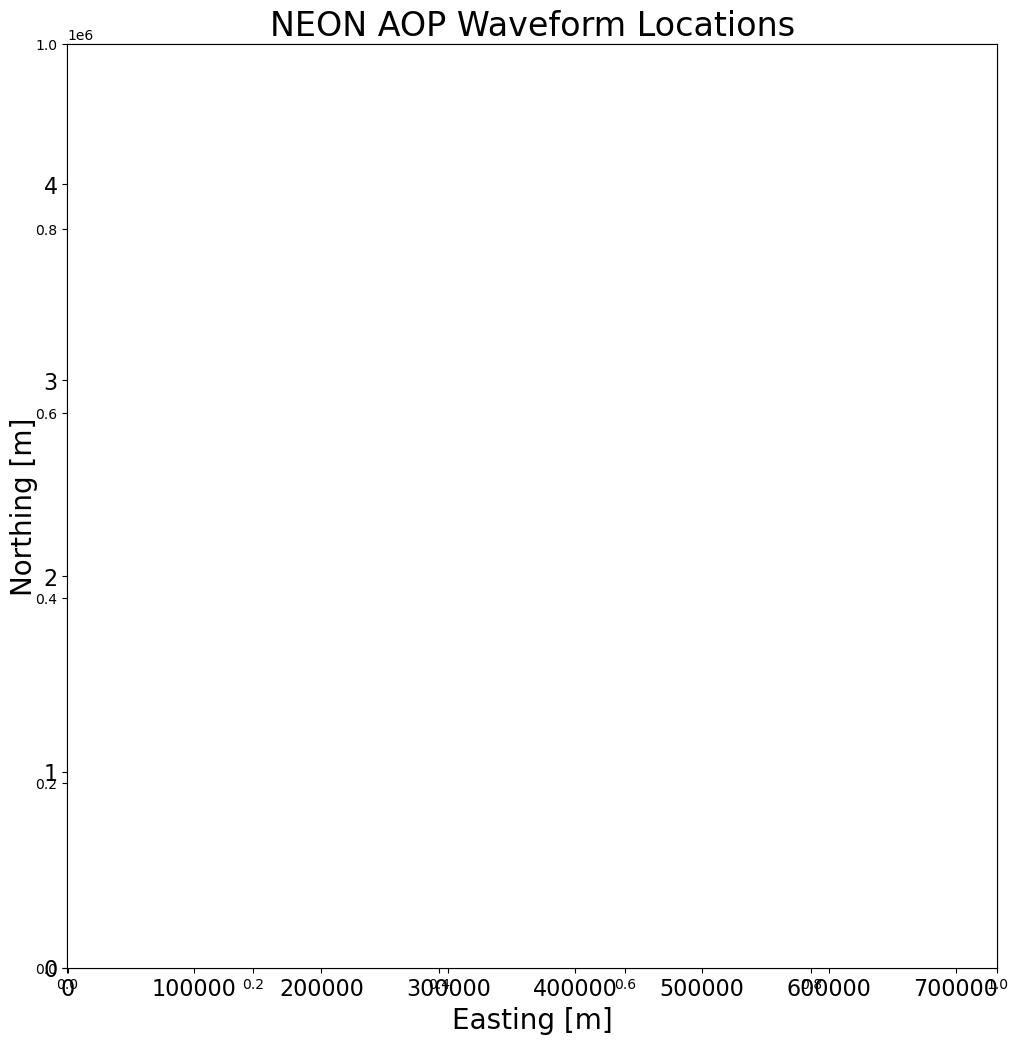

In [112]:
# Plot data coverage
start = time.time()
xmin = np.min(utmEasting_bin0_array) - 100.0
xmax = np.max(utmEasting_bin0_array) + 100.0
ymin = np.min(utmNorthing_bin0_array) - 100.0
ymax = np.max(utmNorthing_bin0_array) + 100.0
print(f"Easting(x) min: {xmin}, Easting(x) max: {xmax}, Northing(y) min: {ymin}, Northing(y) max: {ymax}")

plt.subplots(figsize=(12*1.0, 12*1.0))
ax = plt.axes()
ax.set_xlim((xmin,xmax))
ax.set_ylim((ymin,ymax))
ax.tick_params(axis='both',which='major',labelsize=16)
ax.set_title('NEON AOP Waveform Locations', size = 24)
ax.set_xlabel('Easting [m]', size = 20)
ax.set_ylabel('Northing [m]', size = 20)
ax.scatter(waveform_easting_firstreturn_array, waveform_northing_firstreturn_array, c = waveform_rgb_lut1[0:100], cmap = 'rainbow', s = 4, zorder = 2)

print(waveform_easting_firstreturn_array[0])
plt.show() 
end = time.time()
print(f"Processing time {end-start}s")


Easting: 732928.7331200006, Northing 4717496.750319996
(732341.16, 732342.98)
(4717486.32, 4717486.4)


/var/folders/1x/c62s76gd6tncnjmr6r84hwlh0000gn/T/ipykernel_37542/916610031.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gps_timestamp = np.double(gps_timestamp_T) * T_scale_factor + T_offset
/var/folders/1x/c62s76gd6tncnjmr6r84hwlh0000gn/T/ipykernel_37542/916610031.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_anchor = np.double(anchor_X) * x_scale_factor + x_offset
/var/folders/1x/c62s76gd6tncnjmr6r84hwlh0000gn/T/ipykernel_37542/916610031.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performin

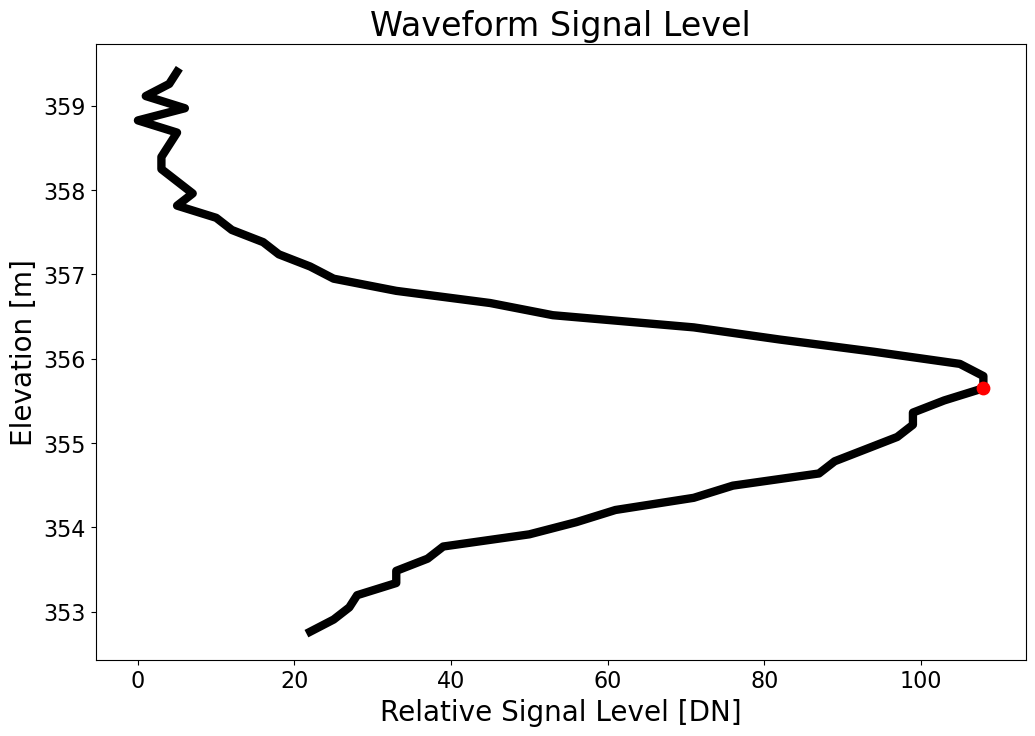

In [245]:
# Plot a few waveforms
fig, (ax1) = plt.subplots(1, 1, figsize=(12, 8))

waveform_files = waveform_file.split('.')
pls_file = waveform_files[0] + '.pls'
wvs_file = waveform_files[0] + '.wvs'
readbin_pls_file = open(pls_file,"rb")
readbin_pls_file.seek(0,0)
readbin_wvs_file = open(wvs_file,"rb")
readbin_wvs_file.seek(0,0)    

iPulse = 3500

dxdydz = dxdydz_array[iPulse,:]
xyz_bin0 = xyz_bin0_array[iPulse,:]
xyz_lastbin = xyz_lastbin_array[iPulse,:]

    
# Read waveform
waveform, waveform_x_axis, waveform_y_axis, waveform_z_axis, offset = read_NEONAOP_pulsewaves_waveform(readbin_pls_file,readbin_wvs_file,iPulse,offset_to_pulse_data,pulse_size,T_scale_factor,T_offset,x_scale_factor,x_offset,y_scale_factor,y_offset,z_scale_factor,z_offset,sampling_record_pulse_descriptor_index_lookup_array,pulse_descriptor_optical_center_to_anchor_point_array,pulse_descriptor_number_of_extra_wave_bytes_array,pulse_descriptor_number_of_samplings_array,sampling_record_bits_for_duration_from_anchor_array,sampling_record_scale_for_duration_from_anchor_array,sampling_record_offset_for_duration_from_anchor_array,sampling_record_bits_for_number_of_segments_array,sampling_record_bits_for_number_of_samples_array,sampling_record_number_of_segments_array,sampling_record_number_of_samples_array,sampling_record_bits_per_sample_array)
print(f"Easting: {np.min(waveform_x_axis)}, Northing {np.max(waveform_y_axis)}")

print(waveform_x_range)
print(waveform_y_range)
# Evaluate waveform
waveform_intensity_threshold = 32.0

# Peak location indices
return_location_count, return_peak_location_list, return_location_list_x, return_intensity_list = waveform_peak_detection(waveform,waveform_intensity_threshold)

# Get peak locations in form of easting and northing
peak_location_x = waveform_x_axis[return_peak_location_list]
peak_location_y = waveform_y_axis[return_peak_location_list]

ax1.tick_params(axis='both',which='major',labelsize=16)
ax1.set_title('Waveform Signal Level', size = 24)
ax1.set_xlabel('Relative Signal Level [DN]', size = 20)
ax1.set_ylabel('Elevation [m]', size = 20)
ax1.plot(waveform,waveform_z_axis,color='black',linewidth=6,zorder=1)
ax1.scatter(return_intensity_list,waveform_z_axis[return_peak_location_list],color='red',s=80,zorder=2)

readbin_pls_file.close()
readbin_wvs_file.close()


In [246]:
# Input: Laz file, easting and northing locations of waveform
# Output: Graph of points at those locations
def plot_point_cloud_data(laz_file, x_locations, y_locations):
    
    point_cloud=laspy.read(laz_file)
    point_cloud_xyz = np.round(point_cloud.xyz, decimals=2)
    
    # Retrieve boundaries of location data
    x_loc_min = np.min(x_locations)
    x_loc_max = np.max(x_locations)
    y_loc_min = np.min(y_locations)
    y_loc_max = np.max(y_locations)

    # Get mask from location
    mask = (point_cloud_xyz[:, 0] >= x_loc_min) & (point_cloud_xyz[:, 0] <= x_loc_max) & \
       (point_cloud_xyz[:, 1] >= y_loc_min) & (point_cloud_xyz[:, 1] <= y_loc_max)

    masked_indices = np.where(mask)[0]
    masked_point_cloud = point_cloud_xyz[mask]
    print(masked_point_cloud)
    
    # Plot data
    # Z is elevation
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(masked_point_cloud[:, 0], masked_point_cloud[:, 1], masked_point_cloud[:, 2], color='red', s=5)
    ax.set_xlabel("Easting")
    ax.set_ylabel("Northing")
    ax.set_zlabel("Elevation")
    ax.set_title("Waveform Point Cloud Visualization")
    plt.show()

[[7.32929100e+05 4.71749673e+06 3.53620000e+02]
 [7.32929730e+05 4.71749674e+06 3.53620000e+02]
 [7.32930400e+05 4.71749675e+06 3.53370000e+02]]


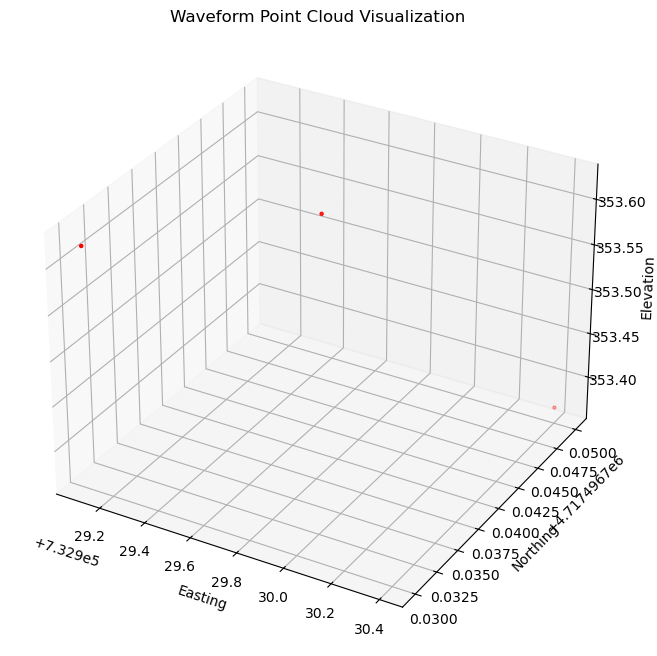

In [244]:
plot_point_cloud_data(point_cloud_file_laz, waveform_x_axis, waveform_y_axis)

In [240]:
def plot_full_point_cloud_data(laz_file):
    point_cloud=laspy.read(laz_file)
    point_cloud_xyz = point_cloud.xyz
    factor=100
    points_dec = point_cloud_xyz[::factor]
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points_dec[:,0],points_dec[:,1],points_dec[:,2],color='blue',s=4)
    plt.show()

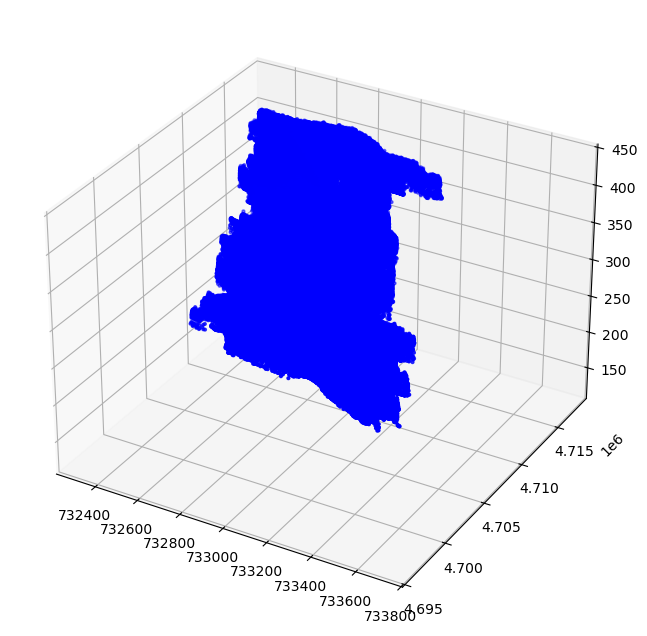

In [241]:
plot_full_point_cloud_data(point_cloud_file_laz)